LinearRegression → CV RMSE = 32.6062 | Best Params: {}
Ridge           → CV RMSE = 32.6057 | Best Params: {'ridge__alpha': 0.01}
Lasso           → CV RMSE = 31.9244 | Best Params: {'lasso__alpha': 1.0}
ElasticNet      → CV RMSE = 32.6169 | Best Params: {'en__alpha': 0.001, 'en__l1_ratio': 0.8}
RandomForest    → CV RMSE = 186.4583 | Best Params: {'max_depth': 10, 'n_estimators': 200}

[LinearRegression] Test Metrics
  MSE  = 587.2410
  RMSE = 24.2331
  MAE  = 18.2999
  R²   = 0.9226


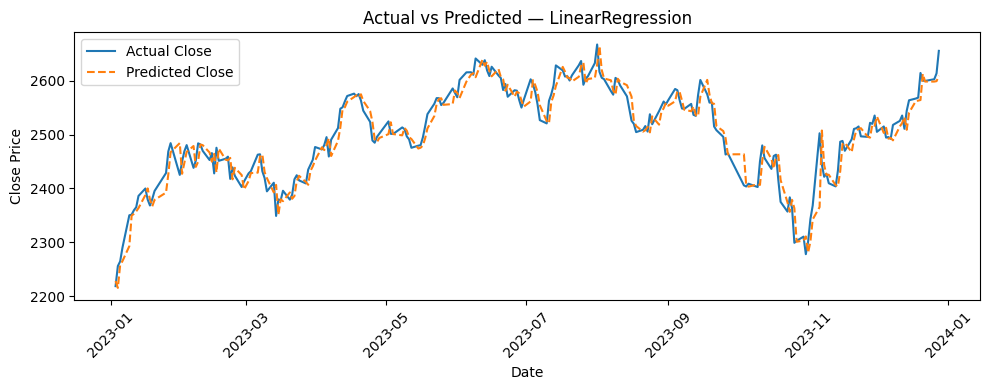

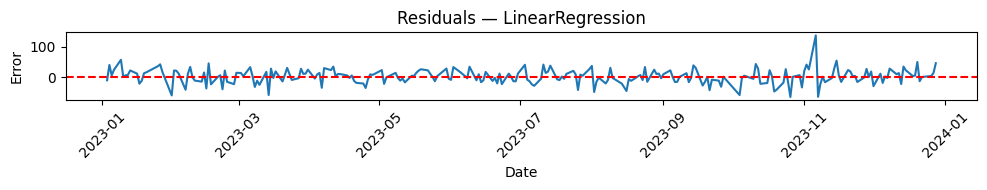


[Ridge] Test Metrics
  MSE  = 586.9546
  RMSE = 24.2271
  MAE  = 18.3005
  R²   = 0.9226


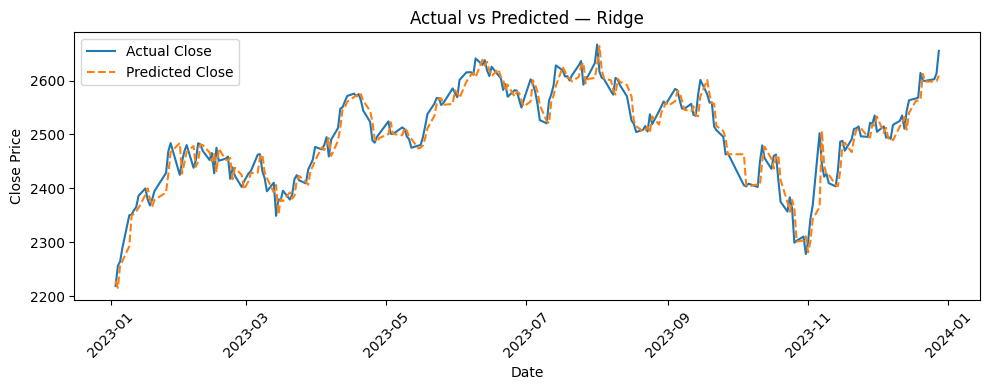

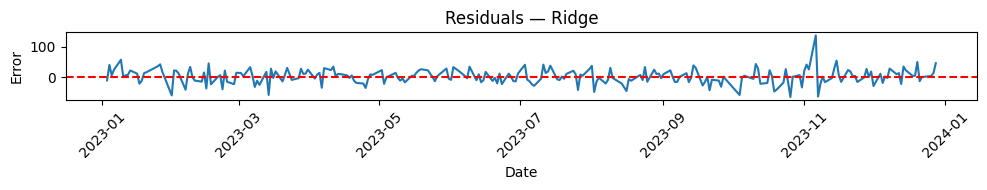


[Lasso] Test Metrics
  MSE  = 579.4721
  RMSE = 24.0722
  MAE  = 18.2528
  R²   = 0.9236


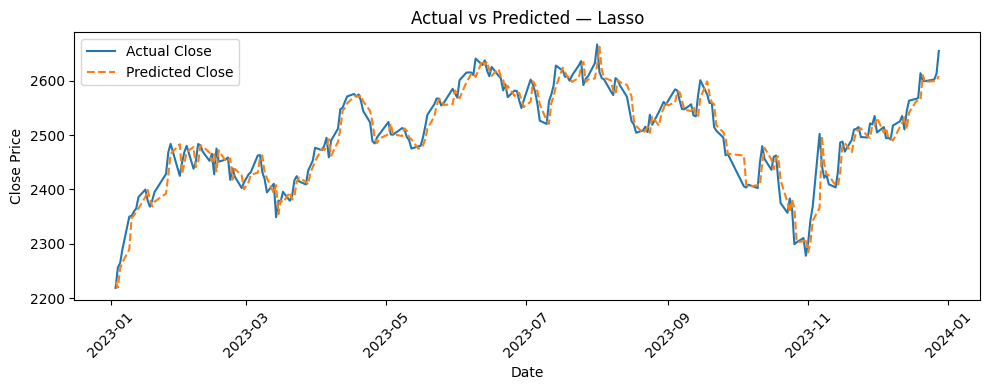

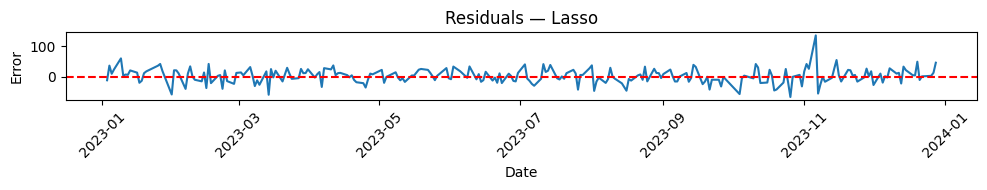


[ElasticNet] Test Metrics
  MSE  = 583.8746
  RMSE = 24.1635
  MAE  = 18.3208
  R²   = 0.9230


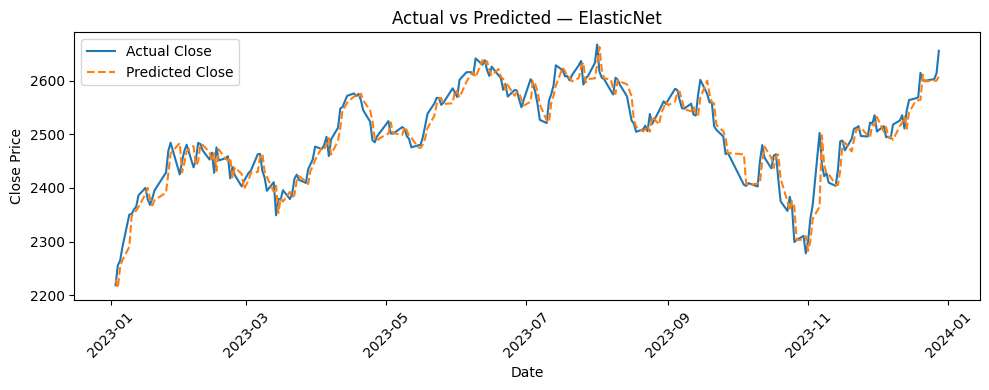

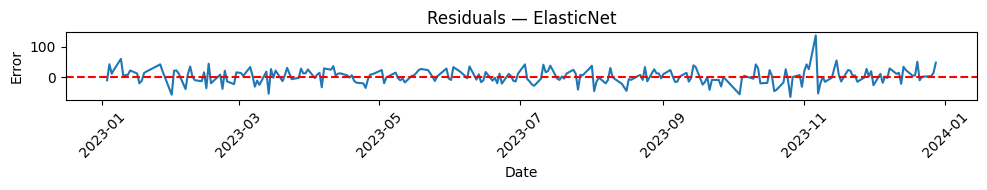


[RandomForest] Test Metrics
  MSE  = 749.4974
  RMSE = 27.3770
  MAE  = 21.3255
  R²   = 0.9012


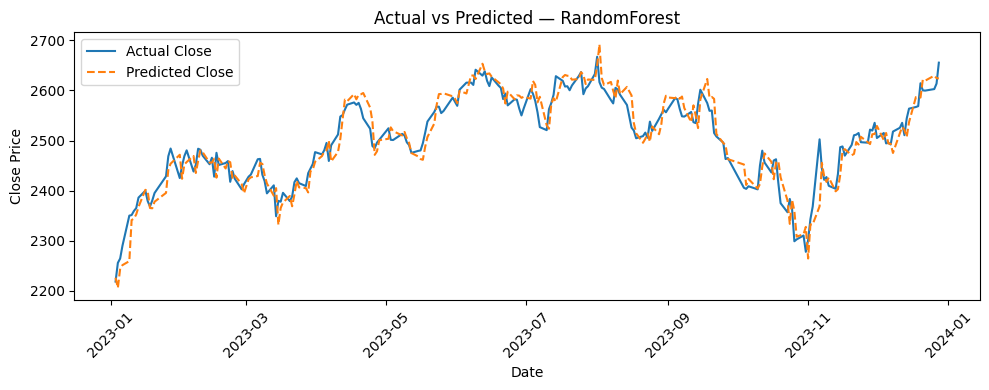

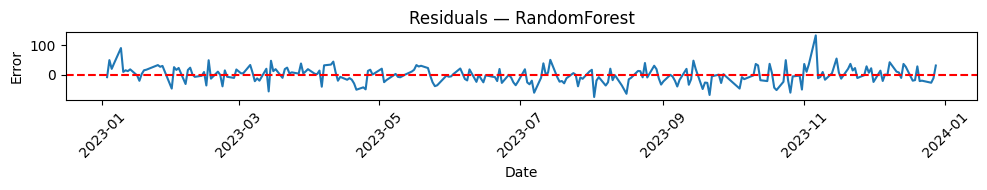

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# 1) Load data + sort by date
def read_data(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

df_train = read_data('/home/kdh02061/quantum/datasets/kospi_train.csv')
df_test  = read_data('/home/kdh02061/quantum/datasets/kospi_test.csv')

# 2) Generate lag-1 features
for df in (df_train, df_test):
    df['Prev_Open']   = df['Open'].shift(1)
    df['Prev_Low']    = df['Low'].shift(1)
    df['Prev_High']   = df['High'].shift(1)
    df['Prev_Close']  = df['Close'].shift(1)
    df['Prev_Volume'] = df['Volume'].shift(1)

train = df_train.dropna().reset_index(drop=True)
test  = df_test .dropna().reset_index(drop=True)

X_train = train[['Prev_Open','Prev_Low','Prev_High','Prev_Close','Prev_Volume']]
y_train = train['Close']
X_test  = test [['Prev_Open','Prev_Low','Prev_High','Prev_Close','Prev_Volume']]
y_test  = test ['Close']

# 3) Define models and hyperparameters
tscv = TimeSeriesSplit(n_splits=5)
models = {
    'LinearRegression': (
        Pipeline([('scaler', StandardScaler()),
                  ('lr', LinearRegression())]),
        {}
    ),
    'Ridge': (
        Pipeline([('scaler', StandardScaler()),
                  ('ridge', Ridge())]),
        {'ridge__alpha': [0.01, 0.1, 1.0, 10.0]}
    ),
    'Lasso': (
        Pipeline([('scaler', StandardScaler()),
                  ('lasso', Lasso(max_iter=50000, tol=1e-4))]),
        {'lasso__alpha': [0.001, 0.01, 0.1, 1.0]}
    ),
    'ElasticNet': (
        Pipeline([('scaler', StandardScaler()),
                  ('en', ElasticNet(max_iter=50000, tol=1e-4))]),
        {'en__alpha': [0.001, 0.01, 0.1, 1.0],
         'en__l1_ratio': [0.2, 0.5, 0.8]}
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [100, 200], 'max_depth': [3, 5, 10]}
    ),
}

# 4) Train with GridSearchCV & save best models
best_models = {}
for name, (est, params) in models.items():
    gs = GridSearchCV(est, params,
                      cv=tscv,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    cv_rmse = np.sqrt(-gs.best_score_)
    print(f"{name:15} → CV RMSE = {cv_rmse:.4f} | Best Params: {gs.best_params_}")

# 5) Evaluate on test set and visualize (MSE, RMSE, MAE, R², residuals)
for name, model in best_models.items():
    y_pred    = model.predict(X_test)
    residuals = y_test.values - y_pred

    # Calculate metrics
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    # Print metrics
    print(f"\n[{name}] Test Metrics")
    print(f"  MSE  = {mse:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R²   = {r2:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 4))
    plt.plot(test['Date'], y_test,  label='Actual Close')
    plt.plot(test['Date'], y_pred, '--', label='Predicted Close')
    plt.title(f'Actual vs Predicted — {name}')
    plt.xlabel('Date'); plt.ylabel('Close Price')
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.show()

    # Plot residuals over time
    plt.figure(figsize=(10, 2))
    plt.plot(test['Date'], residuals, label='Residual (Actual - Pred)')
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f'Residuals — {name}')
    plt.xlabel('Date'); plt.ylabel('Error')
    plt.xticks(rotation=45); plt.tight_layout()
    plt.show()
